# Section 8 - Image Recognition with Convolutional Neural Networks(CNN) - PyTorch



# PyTorch Instalation

In [0]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

## Initializing GPU Usage


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")         # Analyzing GPU availability

## Making and Configuring the dataset

> ### Some explanations...
> - ***Tensors for images***: [(BatchIndex, NumberOfChannels, ImagesHeight, ImagesWidth)] -> [(BI, C, H, W)].
> - ***transforms.Resize((28,28))***: 
> - ***transforms.ToTensor()***: Convert the numpy array, in this case an image, to a float tensor format;
> - ***transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))***: Normalize the values of each channel of the tensor image. The first set of brackets is the mean and in the second set of brackets is the standard deviation. For images with 3 channels of color.

> - ***training_dataset and validation_dataset***: Load the train and validation MNIST dataset from torchvision datasets. The load is done downloading the dataset and saving in the root directory;
> - ***training_loader and validation_loader***: A training loader and validation loader are what we use to specify the training batches. In MNIST dataset, there are 60000 images for training. It can be too much images to load at once in the computer memory, so it is better to use image batches in the training process. For every Epoch, is performed a singles pass through the entire dataset and it occurs in batches;
> - ***NumberOfBatches*** = DatasetSize/BatchSize

In [0]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))             # For images with 1 channel of color.
                               ])

training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)



In [0]:
# This function convert an image in tensor format to numpy format.
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()                                 # Convert from tensor to numpy.
  image = image.transpose(1, 2, 0)                                              # Transpose from (1, 28, 28) to (28, 28, 1)
  print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))         # Is the inverse of the normalization made in the beginnig(transforms.Normalize((0.5,), (0.5,))).
  image = image.clip(0, 1)
  return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


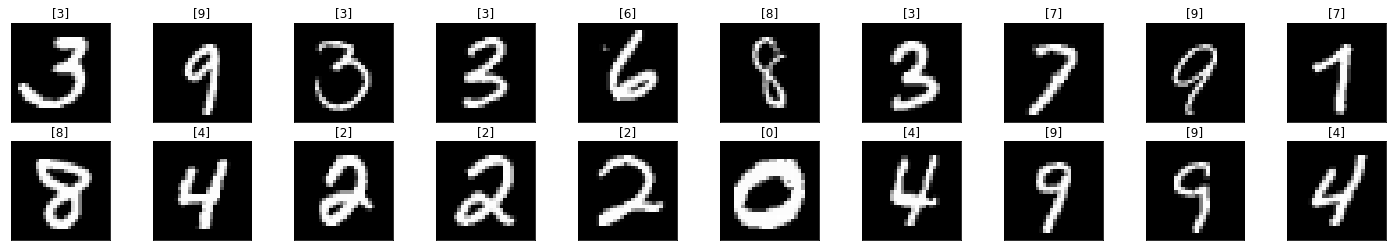

In [0]:
# Plot some images from the first batch.
# iter() -> Create an object that allows us to go through the iterable training_loader, one element at a time. 
dataiter = iter(training_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])
  

## Making and Configuring the CNN - Model Class Constructor

In [0]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 20, 5, 1)
      self.conv2 = nn.Conv2d(20, 50, 5, 1)
      self.fc1 = nn.Linear(4*4*50, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*50)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [0]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

> ### The ***CrossEntropyLoss*** is used for ***MULTICLASS*** classification problems. It is a combination between ***log_softmax*** and ***NLLLoss***.

> ### ***OBS***: When the criterion used is the CrossEntropyLoss, in the end of the CNN, an Activation Function is not used. The last layer is not an Activation Function. The inputs for CrossEntropyLoss are the raw scores and internaly the Softmax Activation Function is applied.



In [0]:
criterion = nn.CrossEntropyLoss()                                               # Defining the Loss function that will be used.

> ### The Adam Optimization Algorithm is a combination of two other extensions of Stochastic Gradiente Descent: *Adagrad* and *RMSprop*. The Adam Optimization Algorithm computes adaptive learning rates for each parameters instead of keep the same learning rates for all parameters.


In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)                   # Definition of Optimization Algorithm.

## Executing the ***TRAIN*** step of the CNN

In [0]:
# Number of epochs or interations.
epochs = 15

# Analyze the losses an every epoch for training dataset.
running_loss_history = []
# Analyze the accuracy an every epoch for training dataset.
running_corrects_history = []

# Analyze the losses an every epoch for validation dataset.
val_running_loss_history = []
# Analyze the accuracy an every epoch for validation dataset. 
val_running_corrects_history = []

# Loop responsible for going through all epochs in the training stage.
for e in range(epochs):

  # Every loss per batch is summed to get the final loss for each epoch for training dataset.
  running_loss = 0.0
  # Every accuracy per batch is summed to get the final accuracy for each epoch for training dataset.
  running_corrects = 0.0

  # Every loss per batch is summed to get the final loss for each epoch for validation dataset.
  val_running_loss = 0.0
  # Every accuracy per batch is summed to get the final accuracy for each epoch for validation dataset.
  val_running_corrects = 0.0
  
  # Loop responsible for submitting all batches of images to training for each epoch.
  for inputs, labels in training_loader:
    inputs = inputs.to(device) # Putting the training inputs on GPU
    labels = labels.to(device) # Putting the training labels on GPU
    # Flatten an 2D array of values(the image) to a single row of values.
    # The process of flattening will generate a single row and 784 columns that each column correspond a pixel value intensity of the image.
    # inputs = inputs.view(inputs.shape[0], -1) # This line is commented because it's no more using Traditional Neural Network, so there is no need to flatten the inputs.
    
    # Outputs returned from the model during the training stage.
    outputs = model(inputs)
    # The outputs are compared to actual labels and then the loss is calculated based on Cross Entropy Loss criterion.
    loss = criterion(outputs, labels) # Loss computed per batch of images.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Each image in the batch will yeild a set of scores that the highest score is the image class predicted by the model.
    # So we want the maximum score in this set of scores.
    _, preds = torch.max(outputs, 1) # the torch.max() function returns a tuple as follows: (maximum score, index for model prediction with highest score(the index is the image class)).
    # Every loss per batch is summed to get the final loss for each epoch. 
    running_loss += loss.item() 
    # The code "(preds == labels.data)" will compare every model prediction to images labels, For example:
    # preds = [2 3 4 5 6] and labels = [2 5 4 5 6]
    # Only the second prediction doesn't match the label, so the output is [1 0 1 1 1]
    # After that, the torch.sum() function will sum all values returned by (preds == labels.data) and will get the number of correct predictions.
    # The number of correct predictions is summed to the "running_corrects" variable.
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad(): # Set, temporary, all required_grads equals to FALSE. This approach save memory.To measure the accuracy of the validation dataset, no grad is required.
      # Loop responsible for submitting all batches of validation images to the model for each epoch.
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device) # Putting the validation inputs on GPU
        val_labels = val_labels.to(device) # Putting the validation labels on GPU
        # Flatten an 2D array of values(the image) to a single row of values.
        # The process of flattening will generate a single row and 784 columns that each column correspond a pixel value intensity of the image.
        # val_inputs = val_inputs.view(val_inputs.shape[0], -1) # This line is commented because it's no more using Traditional Neural Network, so there is no need to flatten the inputs.
        # Outputs returned from the model for validation dataset
        val_outputs = model(val_inputs)
        # The outputs are compared to actual labels and then the loss is calculated based on Cross Entropy Loss criterion.
        val_loss = criterion(val_outputs, val_labels) # Loss computed per batch of images.
        
        # Each image in the validation batch will yeild a set of scores that the highest score is the image class predicted by the model.
        # So we want the maximum score in this set of scores.
        _, val_preds = torch.max(val_outputs, 1) # the torch.max() function returns a tuple as follows: (maximum score, index for model prediction with highest score(the index is the image class)).
        # Every loss per batch is summed to get the final loss for each epoch for validation dataset. 
        val_running_loss += val_loss.item()
        # The code "(val_preds == val_labels.data)" will compare every model prediction to images labels, For example:
        # val_preds = [2 3 4 5 6] and val_labels = [2 5 4 5 6]
        # Only the second prediction doesn't match the label, so the output is [1 0 1 1 1]
        # After that, the torch.sum() function will sum all values returned by (val_preds == val_labels.data) and will get the number of correct predictions.
        # The number of correct predictions is summed to the "val_running_corrects" variable.
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    # Average Loss of an epoch for training dataset.
    epoch_loss = running_loss/len(training_loader) # Acumulated Loss divided by number of images batches on training dataset.
    # Accuracy Loss of an epoch for training dataset.
    epoch_acc = running_corrects.float()/ len(training_loader) # Acumulated correct predictions divided by number of images batches on training dataset.
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    # Average Loss of an epoch for validation dataset.
    val_epoch_loss = val_running_loss/len(validation_loader) # Acumulated Loss divided by number of images batches on validation dataset.
    # Accuracy Loss of an epoch for validation dataset.
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader) # Acumulated correct predictions divided by number of images batches on validation dataset.
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.5749, acc 84.5400 
validation loss: 0.1797, validation acc 94.7700 
epoch : 2
training loss: 0.1499, acc 95.5633 
validation loss: 0.1057, validation acc 96.8900 
epoch : 3
training loss: 0.0987, acc 97.1033 
validation loss: 0.0725, validation acc 97.8600 
epoch : 4
training loss: 0.0766, acc 97.7600 
validation loss: 0.0631, validation acc 98.0600 
epoch : 5
training loss: 0.0641, acc 98.0500 
validation loss: 0.0496, validation acc 98.4600 
epoch : 6
training loss: 0.0545, acc 98.3517 
validation loss: 0.0513, validation acc 98.4700 
epoch : 7
training loss: 0.0490, acc 98.5050 
validation loss: 0.0445, validation acc 98.5800 
epoch : 8
training loss: 0.0432, acc 98.7033 
validation loss: 0.0407, validation acc 98.6700 
epoch : 9
training loss: 0.0401, acc 98.7950 
validation loss: 0.0358, validation acc 98.8900 
epoch : 10
training loss: 0.0356, acc 98.9217 
validation loss: 0.0355, validation acc 98.7000 
epoch : 11
training loss: 0.0337, acc 98.9650 
va

> ## *Overfitting*: is when the model starts to memorize the training dataset but starts to fail in generalize to new data.
> ### If the epoch number is increased too much, the training loss starts to become higher than the validation loss, this is a signal that the model starts to Overfitting.

> ### One way to prevent Overfitting of the model is to use  ***Dropout*** technique.
- ***Dropout Technique***: Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase. This force the remaining hidden layers and neurons to learn(weight updates) and result in a good performance. This technique helps in the generalization of the model.
- ***Dropout Layers(nn.Dropout())***: Is used in between layers that have high number of parameters because this high parameters layers are more likely to overfit and memorize the training data.

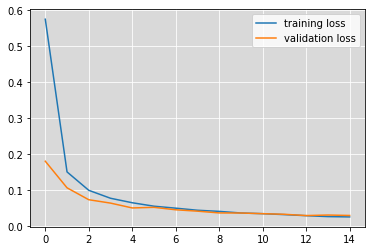

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')

ax = plt.gca()
ax.set_facecolor((0.85, 0.85, 0.85))
plt.grid(color='w', linestyle='solid')
ax.set_axisbelow(True)

plt.legend()

# If the epoch number is increased too much, the training loss starts to become higher than the validation loss, this is a signal that the model starts to Overfitting.
# A model with Overfitting is when the model starts to memorize the training dataset but starts to fail in generalize to new data.

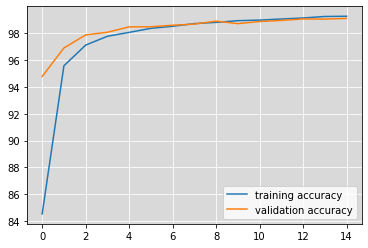

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')

ax = plt.gca()
ax.set_facecolor((0.85, 0.85, 0.85))
plt.grid(color='w', linestyle='solid')
ax.set_axisbelow(True)

plt.legend()

## Executing the ***PREDICT*** step of the CNN

> ### For this step, an image from the internet is downloaded and submitted to the model as an image test. 

In [0]:
!pip3 install pillow==4.0.0

     |████████████████████████████████| 5.6MB 2.7MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


In [0]:
import PIL.ImageOps

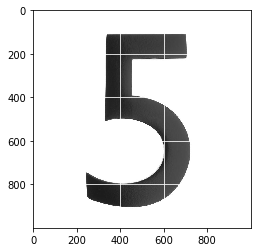

In [0]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)

ax = plt.gca()
ax.set_facecolor((0.85, 0.85, 0.85))
plt.grid(color='w', linestyle='solid')
ax.set_axisbelow(True)

plt.imshow(img)

> ### As the model was generated from a training process that used a training images dataset with 28x28 dimensions, with black background and white foreground, the same caracteristics must be present in the image used to test.

(28, 28, 1)


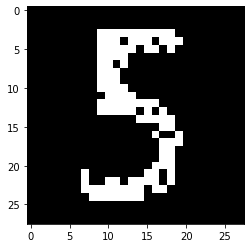

In [0]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)                                                            # Apply all transformations applied in training dataset.
plt.imshow(im_convert(img))                                                     # Convert the image from tensor type to numpy.

In [0]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
#img = img.view(img.shape[0], -1) # Reshape(flatten) the image from 28x28 2D array to a single row (1x784).
output = model(image) # Submit the image to the model
_, pred = torch.max(output, 1) # Pred will store the class of the image.
# The index represents the class and the values in each index position is the probability of the class.
# Index 5 has the higher probability, so 5 is the class.
print(output)
print(pred.item())

tensor([[-10.9235,  -4.3874,  -6.9124,   4.1987,  -5.3552,  11.9823,  -3.8165,
          -1.9635,  -2.0333,  -0.3830]], device='cuda:0',
       grad_fn=<AddmmBackward>)
5


(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


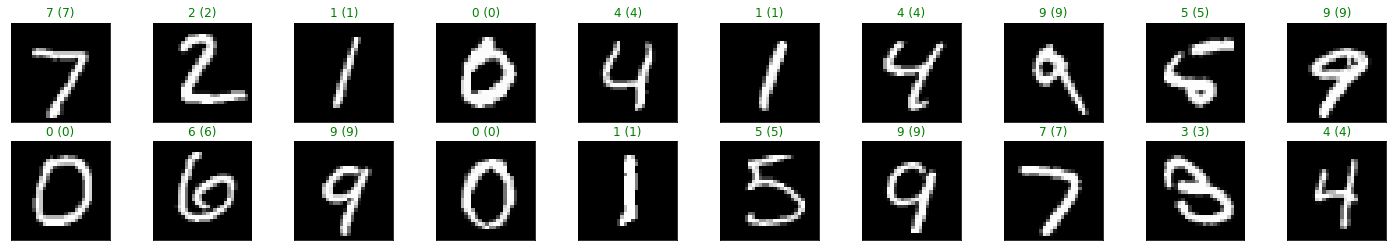

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# images_ = images.view(images.shape[0], -1) # This line is commented because it's no more using Traditional Neural Network, so there is no need to flatten the inputs.
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))